In [ ]:
!pip install opendatasets --quiet
import opendatasets as od
import pandas as pd
import torch
import cv2

import os #4

from torch.utils.data import Dataset #6
from PIL import Image
import os

In [ ]:
#{"username":"nikaavdavd","key":"c02faca605035a6d75e6d0ecbb8d30e3"}
od.download( "https://www.kaggle.com/competitions/automated-video-captioning")

Skipping, found downloaded files in "./automated-video-captioning" (use force=True to force download)


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
train_csv_path = "/content/automated-video-captioning/train.csv"
test_csv_path = "/content/automated-video-captioning/test.csv"
train_dir = "/content/automated-video-captioning/train_videos"
test_dir = '/content/automated-video-captioning/test_videos'

**Обработка текста**

In [ ]:
train_csv = pd.read_csv(train_csv_path)
print(train_csv.shape[0])
train_csv

603


,index,file_name,caption
0,0,0.mp4,A man is working out on a seated chest press m...
1,1,1.mp4,Preparing a bowl with yogurt and assorted fres...
2,2,2.mp4,A man with a muscular build is seen from behin...
3,3,3.mp4,Man exercising by jogging on a pedestrian brid...
4,4,4.mp4,Wristwatch hands moving forward close-up views.
...,...,...,...
598,598,598.mp4,Terrifying Halloween pumpkin with a carved evi...
599,599,599.mp4,Cheerful girl sending messages on cell phone w...
600,600,600.mp4,A person in a light blue shirt is using a lapt...
601,601,601.mp4,"A top-down view of an aesthetic desk setup, wi..."


In [ ]:
train_csv['caption'] = train_csv['caption'].str.lower()
train_csv['caption'] = train_csv['caption'].str.replace("\r", "")
train_csv['caption'] = train_csv['caption'].str.replace("\n", "")
train_csv['caption'] = train_csv['caption'].str.replace("    ", " ")


import string
string.punctuation
punct = list(string.punctuation)
for sign in punct:
    train_csv['caption'] = train_csv['caption'].str.replace(sign, "")


import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
eng_stopwords = stopwords.words("english")
train_csv['caption'] = train_csv['caption'].str.split()
train_csv['caption'] = train_csv['caption'].apply(lambda words: [w for w in words if w not in eng_stopwords])
train_csv['caption'] = train_csv['caption'].apply(lambda words: " ".join(words))


import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('wordnet')
wordnet_lem = WordNetLemmatizer()
def lemmatize_text(text):
    tokenization = nltk.word_tokenize(text)
    lemmatized_words = [wordnet_lem.lemmatize(word) for word in tokenization]
    return " ".join(lemmatized_words)
train_csv['caption'] = train_csv['caption'].apply(lemmatize_text)
train_csv

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,index,file_name,caption
0,0,0.mp4,man working seated chest press machine modern ...
1,1,1.mp4,preparing bowl yogurt assorted freshly chopped...
2,2,2.mp4,man muscular build seen behind intensely worki...
3,3,3.mp4,man exercising jogging pedestrian bridge city ...
4,4,4.mp4,wristwatch hand moving forward closeup view
...,...,...,...
598,598,598.mp4,terrifying halloween pumpkin carved evil face ...
599,599,599.mp4,cheerful girl sending message cell phone takin...
600,600,600.mp4,person light blue shirt using laptop green scr...
601,601,601.mp4,topdown view aesthetic desk setup smooth leftt...


In [ ]:
SOS_token = 0 # Start of seq
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [ ]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

In [ ]:
eng = Lang('eng')
for caption in train_csv['caption']:
    eng.addSentence(caption)

print("Количество уникальных слов:", len(eng.word2index))

Количество уникальных слов: 1897


In [ ]:
tensors = []

for caption in train_csv['caption']:
    tensor = tensorFromSentence(eng, caption)  # Получаем тензор с размерностью (seq_len, 1)
    tensor = tensor.squeeze(1)  # Удаляем размерность 1
    tensors.append(tensor.tolist())  # Преобразуем тензор в список чисел

train_csv['caption'] = tensors

In [ ]:
import numpy as np


def get_caption_length(caption):
    return len(caption)

# Получаем список длин
lengths = [get_caption_length(c) for c in train_csv['caption']]

# Вычисляем среднюю длину и округляем до целого
mean_len = int(round(np.mean(lengths)))

def pad_caption(caption, target_len):
    if len(caption) < target_len:
        caption += [caption[-1]] * (target_len - len(caption))
    elif len(caption) > target_len:
        caption = caption[:target_len]
    return caption

# Применяем к колонке
train_csv['caption'] = train_csv['caption'].apply(lambda c: pad_caption(c, mean_len))

In [ ]:
train_csv

,index,file_name,caption
0,0,0.mp4,"[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1..."
1,1,1.mp4,"[22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 3..."
2,2,2.mp4,"[2, 35, 36, 37, 38, 39, 3, 9, 40, 41, 42, 7, 4..."
3,3,3.mp4,"[2, 50, 51, 52, 53, 54, 55, 1, 1, 1, 1, 1, 1, ..."
4,4,4.mp4,"[56, 57, 58, 59, 60, 61, 1, 1, 1, 1, 1, 1, 1, ..."
...,...,...,...
598,598,598.mp4,"[1883, 1884, 1885, 1886, 1887, 77, 1465, 18, 1..."
599,599,599.mp4,"[1022, 111, 1888, 613, 1013, 1014, 1075, 1849,..."
600,600,600.mp4,"[121, 185, 233, 14, 41, 467, 732, 655, 12, 188..."
601,601,601.mp4,"[1890, 61, 1045, 1815, 729, 1360, 1526, 1462, ..."


**Обработка видео**

In [ ]:
nm=[]
for filename in os.listdir(train_dir):
  nm.append(filename)
print(len(nm))

603


In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision.utils import save_image
import cv2 as cv
from matplotlib import pyplot as plt

cap = cv.VideoCapture('/content/what-on-the-video/train/000690437-arizona-sedona-statue-cowboy-a_preview.mp4')
print(cap)

< cv2.VideoCapture 0x7c66b1635130>


In [ ]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import os
import numpy as np


class VideoDataset(Dataset):
    def __init__(self, dataframe, video_dir, transform=None, mode='train',num_frames = 5):

        self.dataframe = dataframe.reset_index(drop=True)
        self.video_dir = video_dir
        self.transform = transform
        self.mode = mode
        self.num_frames = num_frames

        if self.mode == 'train' or self.mode == 'val':
            if 'caption' not in self.dataframe.columns:
                raise ValueError("Dataframe must contain 'caption' column in train/val mode.")

    def __len__(self):
        return len(self.dataframe)

    def extract_frames(self, cap):
        total_frames = int(cap.get(cv.CAP_PROP_FRAME_COUNT))
        if total_frames < self.num_frames:
            raise ValueError(f"Видео содержит только {total_frames} кадров, требуется минимум {self.num_frames}")

        frame_indices = np.linspace(0, total_frames - 1, self.num_frames, dtype=int)
        frames = []
        for i in range(total_frames):
            ret, frame = cap.read()
            if not ret:
                break
            if i in frame_indices:
                frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
                frame = Image.fromarray(frame)
                if self.transform:
                    frame = self.transform(frame)
                frames.append(frame)
        return frames

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        vid_path = os.path.join(self.video_dir, row['file_name'])
        cap = cv.VideoCapture(vid_path)


        frames = self.extract_frames(cap)
        cap.release()
        video_tensor = torch.stack(frames)


        if self.mode in ['train', 'val']:
            caption = row['caption'] #str
            return video_tensor, torch.tensor(caption)
        else:
            return video_tensor

In [ ]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(train_csv, test_size=0.1, random_state=42)
print(train_df.shape, val_df.shape)

(542, 3) (61, 3)


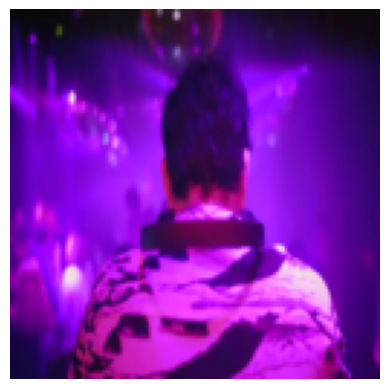

tensor([ 142,  271,  282,  272,  273, 1572,  185,  167,  188,   21, 1573,  172,
         800, 1574,    1])


In [ ]:
from torch.utils.data import DataLoader


transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

train_dataset = VideoDataset(train_df, video_dir=train_dir, transform=transform, mode='train')
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataset = VideoDataset(val_df, video_dir=train_dir, transform=transform, mode='val')
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)

for frame, caption in train_loader:
    img = frame[0,0].permute(1, 2, 0)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    #print(caption.shape)
    print(caption[0])
    #print(frame.shape)
    break

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

class Simple3DCNNEncoder(nn.Module):
    def __init__(self, hid_dim, n_layers):
        super().__init__()
        self.hid_dim = hid_dim
        self.n_layers = n_layers

        resnet = models.resnet18()
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])  # Remove FC

        self.feature_dim = 512

        self.fc = nn.Linear(self.feature_dim, self.hid_dim)
        self.bn = nn.BatchNorm1d(self.hid_dim)

    def forward(self, x):
        B, T, C, H, W = x.shape
        x = x.view(B * T, C, H, W)

        with torch.no_grad():
            features = self.backbone(x)  # shape: [B*T, 512, 1, 1]
            features = features.squeeze()  # shape: [B*T, 512]

        features_proj = self.fc(features)  # shape: [B*T, hid_dim]

        features_seq = features_proj.view(B, T, -1)  # shape: [B,T,hid_dim]

        last_output = features_seq[:, -1, :]  # shape: [B,hid_dim]
        #print("Last output shape:", last_output.shape)

        hidden = self.bn(last_output)  # shape: [B,hid_dim]
        #print("Hidden after BN:", hidden.shape)

        return hidden

In [ ]:
class CharLSTMDecoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers):
        super().__init__()

        self.output_dim = output_dim
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers

        self.embedding = nn.Embedding(output_dim, emb_dim)

        self.lstm = nn.LSTM(emb_dim, hid_dim, num_layers=n_layers, batch_first=True)

        self.fc = nn.Linear(hid_dim, output_dim)

    def forward(self, input, hidden):
        # input: [B] — один токен на каждый элемент в батче
        if input.dim() == 1:
            input = input.unsqueeze(1)  # [B] → [B, 1]

        embedded = self.embedding(input)  # [B, 1, emb_dim]

        output, hidden = self.lstm(embedded, hidden)  # output: [B, 1, hid_dim]

        prediction = self.fc(output.squeeze(1))  # [B, output_dim]

        return prediction, hidden


In [ ]:
teacher_forcing_ratio = 0.5
import random

def train_step(frame_batch, caption_batch, encoder, decoder,
               encoder_optimizer, decoder_optimizer, criterion,
               max_length, teacher_forcing_ratio=0.5):
    encoder.train()
    decoder.train()

    batch_size = frame_batch.size(0)
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    # Прогон через энкодер
    encoder_hidden = encoder(frame_batch)  # [n_layers, B, hid_dim]

    decoder_hidden = (
        encoder_hidden.unsqueeze(0).repeat(2, 1, 1),  # expand to [n_layers, B, hid_dim]
        torch.zeros_like(encoder_hidden).unsqueeze(0).repeat(2, 1, 1)
    )

    decoder_input = torch.full((batch_size,), SOS_token, dtype=torch.long, device=device)   # [B, 1]

    loss = 0
    target_length = caption_batch.size(1)

    use_teacher_forcing = random.random() < teacher_forcing_ratio

    if use_teacher_forcing:
        for t in range(target_length):

            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            #print(decoder_output.shape)
            #print(decoder_output)
            #print(caption_batch.shape)
            #print(caption_batch)
            loss += criterion(decoder_output.squeeze(1), (caption_batch[:, t] -1)) #-1 для каждого значения
            decoder_input = caption_batch[:, t].unsqueeze(1)
    else:
        # Используем предсказания модели как вход
        for t in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            topv, topi = decoder_output.topk(1)  # [B, 1, vocab_size] → [B, 1]
            decoder_input = topi.detach()  # следующий вход — предсказанный токен

            loss += criterion(decoder_output.squeeze(1), caption_batch[:, t])
            # Можно добавить EOS_token проверку, если нужно

    loss.backward()
    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length


In [ ]:
def tensorToSentence(lang, tensor):
    sentence = []

    if isinstance(tensor, torch.Tensor):
        for idx in tensor:
            idx = idx.item()
            if idx == EOS_token:
                break
            word = lang.index2word.get(idx, "<UNK>")
            sentence.append(word)
    elif isinstance(tensor, (list, np.ndarray)):
        for idx in tensor:
            if idx == EOS_token:
                break
            word = lang.index2word.get(idx, "<UNK>")
            sentence.append(word)
    else:
        raise TypeError("Input tensor must be a torch.Tensor, list, or numpy.ndarray")

    return ' '.join(sentence)

In [ ]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

def evaluation(frame_batch, caption_batch, encoder, decoder,
               encoder_optimizer, decoder_optimizer, criterion,
               max_length, teacher_forcing_ratio=0.5):
    batch_size = frame_batch.size(0)
    encoder.eval()
    decoder.eval()

    # Прогон через энкодер
    encoder_hidden = encoder(frame_batch)  # [n_layers, B, hid_dim]

    decoder_hidden = (
        encoder_hidden.unsqueeze(0).repeat(2, 1, 1),  # expand to [n_layers, B, hid_dim]
        torch.zeros_like(encoder_hidden).unsqueeze(0).repeat(2, 1, 1)
    )

    decoder_input = torch.full((batch_size,), SOS_token, dtype=torch.long, device=device)   # [B]

    loss = 0
    target_length = caption_batch.size(1)

    use_teacher_forcing = random.random() < teacher_forcing_ratio

    bleu_score = 0

    # Для BLEU можно сохранить предсказания
    predictions = []

    with torch.no_grad():
        for t in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input.unsqueeze(1), decoder_hidden)
            # decoder_output: [B, vocab_size]
            loss += criterion(decoder_output.squeeze(1), caption_batch[:, t] - 1)

            # Предсказание на текущем шаге
            topv, topi = decoder_output.topk(1)
            predicted_word = topi.squeeze(1)  # [B]

            predictions.append(predicted_word.cpu().numpy())

            if use_teacher_forcing:
                decoder_input = caption_batch[:, t]
            else:
                decoder_input = predicted_word

        # Вычисление BLEU по всей последовательности
        # Предположим у вас есть функция compute_bleu(predicted_seq, target_seq)
        # Например:
        predicted_sequences = np.array(predictions).T.tolist()  # [batch_size][seq_len]
        #print(predicted_sequences)
        #print(caption_batch)
        smoothing = SmoothingFunction().method1  # Или другой метод сглаживания

        for pred_seq, true_seq in zip(predicted_sequences, caption_batch.cpu().numpy()):
            true_seq_list = true_seq.tolist()
            pred_words = tensorToSentence(eng, pred_seq)  # vocab - ваш словарь
            true_words = tensorToSentence(eng, true_seq_list)

            if len(pred_words) > 0 and len(true_words) > 0:
                bleu_score += sentence_bleu([true_words], pred_words, smoothing_function=smoothing)
            else:
                bleu_score += 0

        print(bleu_score)

    avg_loss = loss.item() / target_length
    avg_bleu = bleu_score / batch_size

    return avg_loss, avg_bleu


In [ ]:
import torch.optim as optim

def trainIters(train_loader, val_loader, encoder, decoder, n_epochs, print_every=100, learning_rate=0.01):
    # Списки для хранения средних значений по эпохам
    train_losses_per_epoch = []
    val_losses_per_epoch = []
    bleu_scores_per_epoch = []

    plot_train_losses = []
    plot_val_losses = []

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)

    # Используем CrossEntropyLoss, так как decoder_output — логиты
    PAD_token = 0
    criterion = nn.CrossEntropyLoss(ignore_index=PAD_token)

    for epoch in range(1, n_epochs + 1):
        # Временные списки для накопления данных за одну эпоху
        epoch_train_losses = []
        epoch_val_losses = []
        epoch_bleu_scores = []

        print_loss_train_total = 0
        print_loss_val_total = 0
        step = 0

        # Training loop
        for frame_batch, caption_batch in train_loader:
            frame_batch = frame_batch.to(device)  # [B, 3, T, H, W]
            caption_batch = caption_batch.to(device)  # [B, L]

            # Обучение на шаге
            loss = train_step(frame_batch, caption_batch, encoder,
                              decoder, encoder_optimizer, decoder_optimizer,
                              criterion, max_length=caption_batch.size(1),
                              teacher_forcing_ratio=0.5)

            epoch_train_losses.append(loss)
            print_loss_train_total += loss
            step += 1

            if step % print_every == 0:
                print_loss_avg_train = print_loss_train_total / print_every
                print(f"Epoch {epoch}, Step {step}, Avg Train Loss: {print_loss_avg_train:.4f}")
                plot_train_losses.append(print_loss_avg_train)
                print_loss_train_total = 0
            print(step)


        # Validation loop
        step = 0
        for frame_batch, caption_batch in val_loader:
            frame_batch = frame_batch.to(device)
            caption_batch = caption_batch.to(device)

            # Валидация и BLEU на этом же шаге (или можно делать реже)
            val_loss, bleu_score = evaluation(frame_batch, caption_batch, encoder,
                                                decoder, encoder_optimizer,
                                                decoder_optimizer,
                                                criterion,
                                                max_length=caption_batch.size(1),
                                                teacher_forcing_ratio=0.5)

            epoch_val_losses.append(val_loss)
            epoch_bleu_scores.append(bleu_score)
            print_loss_val_total += val_loss
            step += 1

            if step % print_every == 0:  # Можно менять частоту сбора валидных данных
                print_loss_avg_val = print_loss_val_total / print_every
                print(f"Epoch {epoch}, Step {step}, Avg Val Loss: {print_loss_avg_val:.4f}, BLEU: {bleu_score:.4f}")
                plot_val_losses.append(print_loss_avg_val)
                print_loss_val_total = 0
            print(step)

        # После каждой эпохи считаем средние значения и добавляем в списки для графика
        avg_train_loss_epoch = sum(epoch_train_losses) / len(epoch_train_losses) if epoch_train_losses else 0.0
        avg_val_loss_epoch = sum(epoch_val_losses) / len(epoch_val_losses) if epoch_val_losses else 0.0
        avg_bleu_epoch = sum(epoch_bleu_scores) / len(epoch_bleu_scores) if epoch_bleu_scores else 0.0

        train_losses_per_epoch.append(avg_train_loss_epoch)
        val_losses_per_epoch.append(avg_val_loss_epoch)
        bleu_scores_per_epoch.append(avg_bleu_epoch)


    # Построение графиков после обучения
    epochs_range = range(1, n_epochs + 1)

    plt.figure(figsize=(15, 4))

    plt.subplot(1, 3, 1)
    plt.plot(epochs_range, train_losses_per_epoch, label='Train Loss')
    plt.plot(epochs_range, val_losses_per_epoch, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss per epoch')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(epochs_range, bleu_scores_per_epoch, label='BLEU Score')
    plt.xlabel('Epoch')
    plt.ylabel('BLEU')
    plt.title('BLEU per epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()
    return 0

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
0.009367206231523003
1
0.006438474004607049
2
0.023701813118163634
3
0.019282435441953256
4
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
0.005311943212211066
1
0.019744613599381483
2
0.05854296663214946
3
0.015651942467138927
4
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
0.9792850689415873
1
0.8991819112373599
2
1.101339630758008
3
0.7020386159601594
4


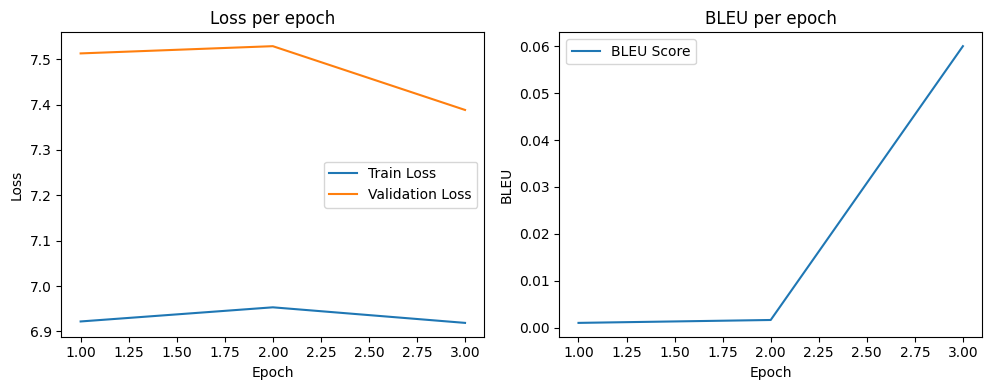

In [ ]:
hidden_size = 2000
encoder1 = Simple3DCNNEncoder(hidden_size, 2).to(device)
decoder1 = CharLSTMDecoder(1900, hidden_size,hidden_size,2).to(device)

trainIters(train_loader, val_loader, encoder1, decoder1, 3, print_every=5000)#30 секунд на шаг
torch.save(encoder1.state_dict(), 'encoder1.pth')
torch.save(decoder1.state_dict(), 'decoder1.pth')

In [ ]:
test_csv = pd.read_csv(test_csv_path)
print(test_csv.shape[0])
test_csv

521


,index,file_name
0,0,0.mp4
1,1,1.mp4
2,2,2.mp4
3,3,3.mp4
4,4,4.mp4
...,...,...
516,516,516.mp4
517,517,517.mp4
518,518,518.mp4
519,519,519.mp4


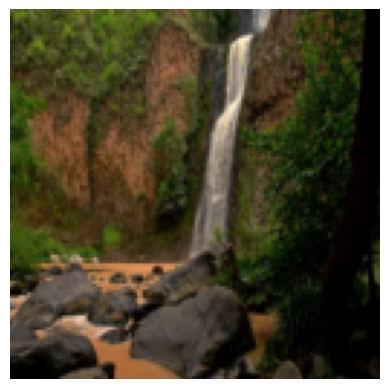

torch.Size([16, 5, 3, 128, 128])


In [ ]:
test_dataset = VideoDataset(test_csv, video_dir=test_dir, transform=transform, mode='test')
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

for frame in test_loader:
    img = frame[0,0].permute(1, 2, 0)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    print(frame.shape)
    break

In [ ]:

answers = []
encoder1.eval()
decoder1.eval()

with torch.no_grad():
    step = 0
    for images in test_loader:
        batch_size = images.size(0)
        images = images.to(device)
        images = images.permute(0, 1, 2, 3, 4)

        encoder_hidden = encoder1(images)

        decoder_hidden = (
            encoder_hidden.unsqueeze(0).repeat(2, 1, 1),  # expand to [n_layers, B, hid_dim]
            torch.zeros_like(encoder_hidden).unsqueeze(0).repeat(2, 1, 1)
        )
        decoder_input = torch.full((batch_size,), SOS_token, dtype=torch.long, device=device)
        target_length = 15

        answer = []

        for t in range(target_length):
            decoder_output, decoder_hidden = decoder1(decoder_input.unsqueeze(1), decoder_hidden)

            #print(f"decoder_output.shape: {decoder_output.shape}")
            # Предполагается [B, vocab_size]
            #print(f"decoder_output: {decoder_output}")

            caption_batch = torch.argmax(decoder_output, dim=1)  # [B]
            #print(f"caption_batch shape: {caption_batch.shape}")
            #print(f"caption_batch: {caption_batch}")

            decoder_input = caption_batch
            answer.append(caption_batch.cpu().numpy() + 1)

        answers.append(answer)

        step += 1
        print(f"Step {step}")

answers_df = pd.DataFrame(answers)
print(answers_df)

Step 1
Step 2
Step 3
Step 4
Step 5
Step 6
Step 7
Step 8
Step 9
Step 10
Step 11
Step 12
Step 13
Step 14
Step 15
Step 16
Step 17
Step 18
Step 19
Step 20
Step 21
Step 22
Step 23
Step 24
Step 25
Step 26
Step 27
Step 28
Step 29
Step 30
Step 31
Step 32
Step 33
                                                   0   \
0   [80, 167, 80, 80, 80, 80, 80, 80, 80, 80, 80, ...   
1   [80, 81, 80, 167, 167, 80, 80, 80, 80, 80, 80,...   
2   [80, 80, 167, 80, 80, 80, 167, 80, 80, 81, 167...   
3   [167, 80, 80, 80, 81, 80, 80, 80, 80, 167, 167...   
4   [80, 80, 167, 80, 80, 80, 80, 80, 167, 80, 80,...   
5   [80, 167, 80, 80, 80, 80, 80, 80, 80, 167, 80,...   
6   [80, 80, 81, 167, 80, 80, 167, 80, 80, 80, 167...   
7   [80, 80, 80, 80, 167, 80, 80, 167, 80, 80, 81,...   
8   [80, 80, 80, 167, 80, 80, 80, 80, 80, 80, 80, ...   
9   [80, 80, 167, 80, 80, 80, 80, 80, 80, 167, 80,...   
10  [80, 167, 80, 80, 80, 80, 80, 80, 80, 80, 80, ...   
11  [167, 80, 80, 80, 80, 80, 80, 167, 80, 80, 80,...   
12  

In [ ]:
lengths = answers_df.applymap(len)
max_len = lengths.values.max()

def pad_list(lst, max_len, pad_value=0):
    lst = list(lst)
    return lst + [pad_value] * (max_len - len(lst))

answers_df_padded = answers_df.applymap(lambda x: pad_list(x, max_len))

answers_np = np.array(answers_df_padded.values.tolist())
print(answers_np.shape)  # (3, 2, max_len)

import torch
answers_tensor = torch.tensor(answers_np)
print(answers_tensor.shape)

(33, 15, 16)
torch.Size([33, 15, 16])


<ipython-input-35-5b148dd73a6d>:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  lengths = answers_df.applymap(len)
<ipython-input-35-5b148dd73a6d>:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  answers_df_padded = answers_df.applymap(lambda x: pad_list(x, max_len))


In [ ]:
def tensorToSentence(lang, tensor):

    sentence = []

    for idx in tensor:
        idx = idx.item()
        if idx == EOS_token:
            break
        word = lang.index2word.get(idx, "<UNK>")
        sentence.append(word)

    return ' '.join(sentence)

In [ ]:
caption_df =[]

for cap in answers_tensor:
    for i in range(16):
        #print(cap.shape)
        caption_df.append(tensorToSentence(eng,cap[:,i]))
        #print(caption_df)
        #break

test_caption_df = pd.DataFrame({'caption': caption_df})
test_caption_df = test_caption_df.iloc[:521]
test_caption_df

,caption
0,woman woman woman woman woman woman woman woma...
1,people woman woman woman woman woman woman wom...
2,woman woman woman woman woman woman woman woma...
3,woman woman woman woman woman woman woman woma...
4,woman woman woman woman woman woman woman woma...
...,...
516,people woman woman woman woman woman woman wom...
517,people woman woman woman woman woman woman wom...
518,woman woman woman woman woman woman woman woma...
519,woman woman woman woman woman woman woman woma...


In [ ]:
submission_df = pd.DataFrame({
    'index': range(len(test_csv)),
    'file_name': test_csv['file_name'],
    'caption': test_caption_df['caption']
})
submission_df

,index,file_name,caption
0,0,0.mp4,woman woman woman woman woman woman woman woma...
1,1,1.mp4,people woman woman woman woman woman woman wom...
2,2,2.mp4,woman woman woman woman woman woman woman woma...
3,3,3.mp4,woman woman woman woman woman woman woman woma...
4,4,4.mp4,woman woman woman woman woman woman woman woma...
...,...,...,...
516,516,516.mp4,people woman woman woman woman woman woman wom...
517,517,517.mp4,people woman woman woman woman woman woman wom...
518,518,518.mp4,woman woman woman woman woman woman woman woma...
519,519,519.mp4,woman woman woman woman woman woman woman woma...


In [ ]:
submission_df.to_csv('submission.csv', index=False)